### Imports

In [1]:
# Standard library
import sqlite3
import os

# Third-party
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Local application
from kickbase_api.player_data import (
    get_all_players,
    get_player_id,
    get_player_info,
    get_player_market_value,
    get_player_performance,
)
from kickbase_api.league_data import (
    get_leagues_infos,
    get_budget,
    get_players_on_market,
)
from kickbase_api.user_management import login

### Login to Kickbase

In [2]:
# Load environment variables from .env file
load_dotenv() 
USERNAME = os.getenv("KICK_USER")
PASSWORD = os.getenv("KICK_PASS")

# Login and get token
token = login(USERNAME, PASSWORD)
print("Logged in.")

Logged in.


### Connect to SQLite Database

In [3]:
conn = sqlite3.connect("bundesliga.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS player_data_1d (
    player_id INTEGER,
    team_id INTEGER,
    team_name TEXT,
    first_name TEXT,
    last_name TEXT,
    position TEXT,
    md DATE,
    date DATE,
    p REAL,
    mp INTEGER,
    ppm REAL,
    t1 INTEGER,
    t2 INTEGER,
    t1g INTEGER,
    t2g INTEGER,
    won INTEGER,
    k TEXT,
    mv REAL
);
""")

conn.commit()

### Get Player Data from Kickbase and Store in Database

In [4]:
competition_ids = [1]  # 1 = Bundesliga, 2 = 2. Bundesliga (für mehr Training)
last_mv_values = 365  # in Tagen, max 365
last_pfm_values = 50  # in Spieltagen
reload_data = False

# TODO: Change so this automatically fetches new data if the last entry is not up to date
# Check sysdate and time if before 22:00, then today should have no label for mv_target
# If after 22:00 then new mv available then fetch new data and update existing

if reload_data:
    all_competitions_dfs = []

    for competition_id in competition_ids:
        players = get_all_players(token, competition_id)

        def process_player(player_id):
            player_info = get_player_info(token, competition_id, player_id)
            player_team_id = player_info["team_id"]
            player_df = pd.DataFrame([player_info])

            # Market Value
            mv_df = pd.DataFrame(get_player_market_value(token, competition_id, player_id, last_mv_values))
            if not mv_df.empty:
                mv_df["date"] = pd.to_datetime(mv_df["date"]).sort_values()

            # Performance
            p_df = pd.DataFrame(get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id))
            if not p_df.empty:
                p_df["date"] = pd.to_datetime(p_df["date"]).sort_values()
            else:
                p_df = pd.DataFrame({"date": pd.to_datetime([])})

            # Merge DataFrames
            merged_df = (
                pd.merge_asof(mv_df, p_df, on="date", direction="backward")
                if not mv_df.empty else pd.DataFrame()
            )

            # Get p_df values where p_df.date > max(mv_df.date) and append to merged_df
            if not p_df.empty and not mv_df.empty:
                max_mv_date = mv_df["date"].max()
                additional_p_df = p_df[p_df["date"] > max_mv_date]
                merged_df = pd.concat([merged_df, additional_p_df], ignore_index=True) 

            if not merged_df.empty:
                merged_df = player_df.merge(merged_df, how="cross")
                merged_df["competition_id"] = competition_id

            return merged_df

        comp_dfs = list(map(process_player, players))
        comp_final_df = pd.concat(comp_dfs, ignore_index=True)
        all_competitions_dfs.append(comp_final_df)

    # Combine all competitions
    final_df = pd.concat(all_competitions_dfs, ignore_index=True)

    # Convert k column to string
    final_df["k"] = final_df["k"].apply(
        lambda x: ",".join(map(str, x)) if isinstance(x, list) else (None if x is None else str(x))
    )

    # Save to SQLite
    with sqlite3.connect("bundesliga.db") as conn:
        final_df.to_sql("player_data_1d", conn, if_exists="replace", index=False)


In [5]:
conn = sqlite3.connect("bundesliga.db")
df = pd.read_sql("SELECT * FROM player_data_1d", conn)
conn.close()

### Preprocess Data

In [6]:
# TODO: Change this to replace NaN with other values instead of dropping, so we keep our up-to-date data
#df = df.dropna(subset=["mv_next_day", "mv_target", "next_md", "days_to_next"])

# 1. Sort and filter
df = df.sort_values(["player_id", "date"])
df = df[(df["team_id"] == df["t1"]) | (df["team_id"] == df["t2"])]  # keep only t1 or t2

# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])
df["md"] = pd.to_datetime(df["md"])

# 2. Date and matchday calculations 
df["next_day"] = df.groupby("player_id")["date"].shift(-1) 
df["next_md"] = df.groupby("player_id")["md"].transform(
    lambda x: x.shift(-1).where(x.shift(-1) != x).bfill()
)
df["days_to_next"] = (df["next_md"] - df["date"]).dt.days

# 3. Next day market value
df["mv_next_day"] = df.groupby("player_id")["mv"].shift(-1)
df["mv_target"] = df["mv_next_day"] - df["mv"]
df = df[df["mv"] != 0.0]

# 4. Feature engineering 
# Market value trend 1d
df["mv_change_1d"] = df["mv"] - df.groupby("player_id")["mv"].shift(1)
df["mv_trend_1d"] = df.groupby("player_id")["mv"].pct_change()
df["mv_trend_1d"] = df["mv_trend_1d"].replace([np.inf, -np.inf], 0).fillna(0)

# Market value trend 3d
df["mv_change_3d"] = df["mv"] - df.groupby("player_id")["mv"].shift(3)
df["mv_vol_3d"] = df.groupby("player_id")["mv"].rolling(3).std().reset_index(0,drop=True)

# Market value trend 7d
df["mv_trend_7d"] = df.groupby("player_id")["mv"].pct_change(periods=7)
df["mv_trend_7d"] = df["mv_trend_7d"].replace([np.inf, -np.inf], 0).fillna(0)

## League-wide market context
df["market_divergence"] = (df["mv"] / df.groupby("md")["mv"].transform("mean")).rolling(3).mean()

# 5. Clip outliers in mv_target
Q1 = df["mv_target"].quantile(0.25)
Q3 = df["mv_target"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

df["mv_target_clipped"] = df["mv_target"].clip(lower_bound, upper_bound)

# 6. Fill missing values
df = df.fillna({
    "market_divergence": 1,
    "mv_change_3d": 0,
    "mv_vol_3d": 0,
    "p": 0,
    "ppm": 0,
    "won": -1
})

# 7. Cutout todays values and store them
now = datetime.now()
max_date = (now - timedelta(days=1)) if now.hour <= 22 else now
max_date = max_date.date()

today_df = df[df["date"].dt.date >= max_date]

# Drop those values from today from df
df = df[df["date"].dt.date < max_date]

# 8. Drop rows with NaN in critical columns
df = df.dropna(subset=["mv_change_1d", "next_day", "next_md", "days_to_next", "mv_next_day", "mv_target", "mv_target_clipped"])

C:\Users\lenna\AppData\Local\Temp\ipykernel_17476\2547497827.py:27: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["mv_trend_1d"] = df.groupby("player_id")["mv"].pct_change()
C:\Users\lenna\AppData\Local\Temp\ipykernel_17476\2547497827.py:35: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["mv_trend_7d"] = df.groupby("player_id")["mv"].pct_change(periods=7)


### Select Features and Target Variable

In [7]:
# TODO Features: Fit or Injury and Starting Eleven Prediction
features = [
    "p", "mv", "days_to_next", 
    "mv_change_1d", "mv_trend_1d", 
    "mv_change_3d", "mv_vol_3d",
    "mv_trend_7d", "market_divergence"
]

target = "mv_target_clipped" # or "mv_target"

# Split by time, to avoid data leakage
train = df[df["date"] < "2025-01-01"]
test = df[(df["date"] >= "2025-01-01")]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Train Machine Learning Model

In [8]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
signs_correct = np.sum(np.sign(y_test) == np.sign(y_pred))

print(f"Sign accuracy: {np.round((signs_correct / len(y_test)) * 100, 2)}%")
print(f"RMSE: {np.round(rmse, 2)}")
print(f"MAE: {np.round(mae, 2)}")
print(f"R²: {np.round(r2, 3)}")

Sign accuracy: 66.13%
RMSE: 3031430188.55
MAE: 28062.47
R²: 0.807


### Example Player Prediction

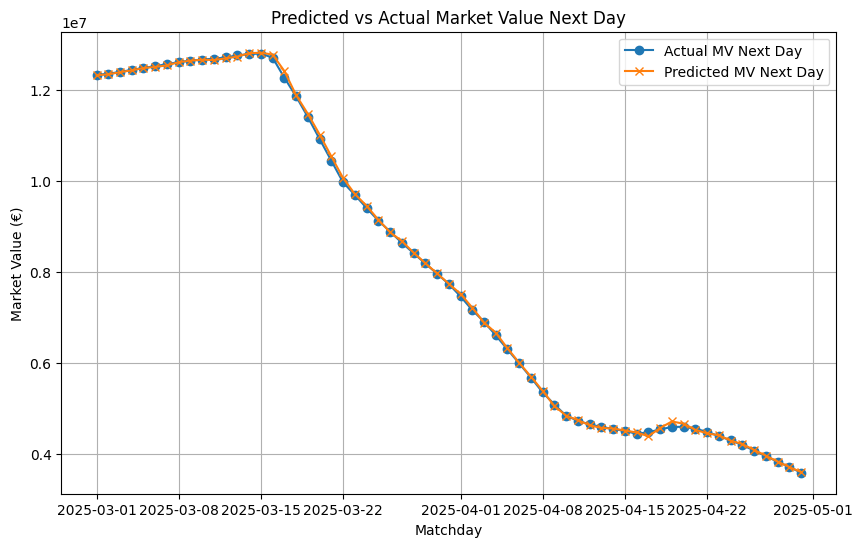

In [9]:
small_test = test[["player_id", "first_name", "last_name", "date", "mv", "mv_next_day", "mv_target"]].copy()

small_test["predicted_mv_target"] = np.round(y_pred, 2)
small_test["predicted_mv_next_day"] = small_test["mv"] + small_test["predicted_mv_target"]


# get error between prediction and actual 
small_test["error"] = small_test["mv_next_day"] - small_test["predicted_mv_next_day"]

# Sort by error ascending

small_test = small_test.sort_values("date")

small_test = small_test[(small_test["last_name"] == "Uzun")]


# Filter small test only between 2025-03 and 2025-04
small_test = small_test[(small_test["date"] >= "2025-03-01") & (small_test["date"] <= "2025-04-30")]


# Plot predicted vs actual mv_next_week
plt.figure(figsize=(10, 6))
plt.plot(small_test["date"], small_test["mv_next_day"], marker='o', label="Actual MV Next Day")
plt.plot(small_test["date"], small_test["predicted_mv_next_day"], marker='x', label="Predicted MV Next Day")
plt.xlabel("Matchday")
plt.ylabel("Market Value (€)")
plt.title("Predicted vs Actual Market Value Next Day")
plt.legend()
plt.grid(True)


### Feature Importance

In [10]:
#perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
#
#perm_df = pd.DataFrame({
#    'feature': features,
#    'importance': perm_importance.importances_mean
#}).sort_values(by='importance', ascending=False)
#
## Plot
#plt.figure(figsize=(10,6))
#plt.barh(perm_df['feature'], perm_df['importance'])
#plt.gca().invert_yaxis()
#plt.title("Feature Importance")
#plt.xlabel("Decrease in Model Score")
#plt.show()

### Predicted vs Actual Values

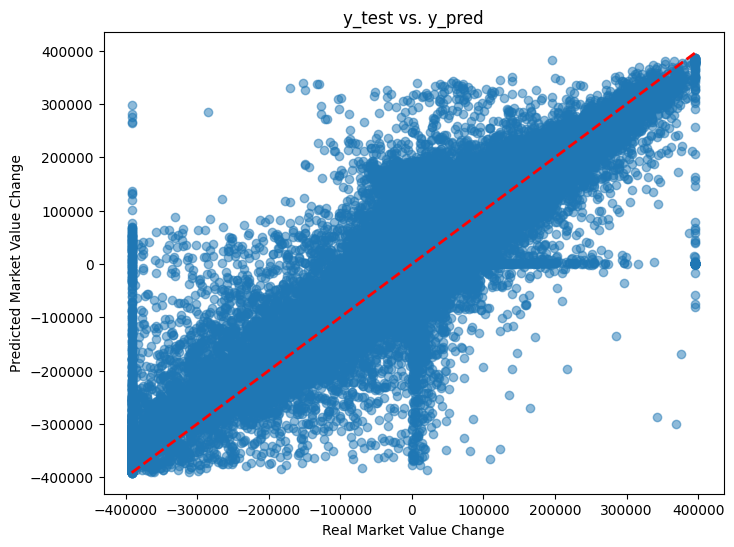

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel("Real Market Value Change")
plt.ylabel("Predicted Market Value Change")
plt.title("y_test vs. y_pred")
plt.show()

### Live Data Prediction

In [12]:
today_df_features = today_df[features]

today_df["predicted_mv_target"] = np.round(model.predict(today_df_features), 2)

# Sort by predicted_mv_target descending
today_df = today_df.sort_values("predicted_mv_target", ascending=False)

# Top 20 predicted_mv_target
display(today_df[["player_id", "first_name", "last_name", "team_name", "date", "p", "mv_change_3d", "mv_change_1d", "mv_trend_1d", "mv", "predicted_mv_target"]].head(20))

# Bottom 20 predicted_mv_target
display(today_df[["player_id", "first_name", "last_name", "team_name", "date", "p", "mv_change_3d", "mv_change_1d", "mv_trend_1d", "mv", "predicted_mv_target"]].tail(20))

,player_id,first_name,last_name,team_name,date,p,mv_change_3d,mv_change_1d,mv_trend_1d,mv,predicted_mv_target
149743,6750,Ilyas,Ansah,Union Berlin,2025-08-28,256.0,1254087.0,402143.0,0.052832,8013923.0,368141.04
61539,3228,Justin,Njinmah,Bremen,2025-08-28,119.0,1164913.0,367605.0,0.045980,8362480.0,328999.99
15044,6293,Danel,Sinani,St. Pauli,2025-08-28,253.0,1087774.0,351020.0,0.042622,8586738.0,310626.31
19815,11259,Andréas,Hountondji,St. Pauli,2025-08-28,104.0,1094682.0,338785.0,0.048147,7375209.0,308527.92
54585,3063,Fabio,Chiarodia,M'gladbach,2025-08-28,91.0,1235867.0,377713.0,0.085945,4772529.0,305952.34
45069,3193,None,Tiago Tomás,Stuttgart,2025-08-28,95.0,1086270.0,345954.0,0.049741,7301079.0,301050.98
10273,11752,Warmed,Omari,Hamburg,2025-08-28,99.0,957478.0,311832.0,0.047434,6885916.0,297995.95
21280,1671,Grischa,Prömel,Hoffenheim,2025-08-28,25.0,1065894.0,327959.0,0.120483,3049993.0,288245.22
118634,4611,Moritz,Jenz,Wolfsburg,2025-08-28,51.0,1036989.0,320019.0,0.042416,7864845.0,283389.61
121562,7877,Andreas,Skov Olsen,Wolfsburg,2025-08-28,229.0,1086214.0,331618.0,0.039114,8809928.0,282343.68


,player_id,first_name,last_name,team_name,date,p,mv_change_3d,mv_change_1d,mv_trend_1d,mv,predicted_mv_target
107654,1862,Raphaël,Guerreiro,Bayern,2025-08-28,0.0,-1277176.0,-418509.0,-0.036501,11047038.0,-346649.41
72884,6745,Victor,Boniface,Leverkusen,2025-08-28,0.0,-1163014.0,-421041.0,-0.036652,11066401.0,-348472.76
71420,4563,Loïc,Badé,Leverkusen,2025-08-28,0.0,-674525.0,-537077.0,-0.034476,15041109.0,-357794.44
44703,3190,Jeff,Chabot,Stuttgart,2025-08-28,74.0,-1107436.0,-507008.0,-0.025013,19762370.0,-358884.76
56781,6319,Franck,Honorat,M'gladbach,2025-08-28,88.0,-888836.0,-569388.0,-0.021306,26154743.0,-363889.47
76178,11913,Claudio,Echeverri,Leverkusen,2025-08-28,-6.0,-1063125.0,-550882.0,-0.045065,11673164.0,-364548.18
110948,3120,Tom,Bischof,Bayern,2025-08-28,0.0,-1388557.0,-491805.0,-0.035646,13305009.0,-364565.69
43239,2758,Nick,Woltemade,Stuttgart,2025-08-28,37.0,-537798.0,-620564.0,-0.018909,32198054.0,-365261.43
104360,9684,Alexis,Claude-Maurice,Augsburg,2025-08-28,0.0,-1254528.0,-430410.0,-0.036667,11307998.0,-366058.09
125588,1639,Nadiem,Amiri,Mainz,2025-08-28,58.0,-1471070.0,-541028.0,-0.014893,35787428.0,-367720.83


In [13]:
# Bid pipeline
# 1. Check available player on market
# 2. Check available budget
# 3. Check how long until next matchday (money cant be negative then)
# 4. Check team size and club limit
# 5. Based upon prediction and other factors

In [14]:
league_infos = get_leagues_infos(token)
league_id = league_infos[0]["id"]

players_on_market = get_players_on_market(token, league_id)
print(players_on_market)


[{'id': '550', 'first_name': 'Stefan', 'last_name': 'Bell', 'team_id': '18', 'position': 2, 'market_value': 9022884, 'prob': 2, 'is_new': False}, {'id': '1918', 'first_name': 'Salih', 'last_name': 'Özcan', 'team_id': '3', 'position': 3, 'market_value': 3089163, 'prob': 4, 'is_new': False}, {'id': '2038', 'first_name': 'Konrad', 'last_name': 'Laimer', 'team_id': '2', 'position': 2, 'market_value': 24317618, 'prob': 2, 'is_new': False}, {'id': '2074', 'first_name': 'Robin', 'last_name': 'Hack', 'team_id': '15', 'position': 3, 'market_value': 17637741, 'prob': 1, 'is_new': False}, {'id': '2274', 'first_name': 'Keven', 'last_name': 'Schlotterbeck', 'team_id': '13', 'position': 2, 'market_value': 10657980, 'prob': 1, 'is_new': False}, {'id': '2373', 'first_name': 'Ozan', 'last_name': 'Kabak', 'team_id': '14', 'position': 2, 'market_value': 500000, 'prob': 5, 'is_new': True}, {'id': '2536', 'first_name': 'Matthias', 'last_name': 'Köbbing', 'team_id': '28', 'position': 1, 'market_value': 5000

### Testinggg

,md,date,p,mp,ppm,t1,t2,t1g,t2g,won,k
0,2024-02-17,2024-02-17,66.0,95,0.694737,23,6,2.0,2.0,NaN,[9]
1,2024-02-25,2024-02-25,111.0,96,1.156250,6,77,1.0,0.0,1.0,None
2,2024-03-03,2024-03-03,75.0,86,0.872093,6,76,1.0,2.0,0.0,[9]
3,2024-03-08,2024-03-08,39.0,76,0.513158,12,6,2.0,0.0,0.0,[9]
4,2024-03-17,2024-03-17,112.0,95,1.178947,6,75,3.0,0.0,1.0,None
5,2024-03-31,2024-03-31,112.0,97,1.154639,19,6,1.0,1.0,NaN,[4]
6,2024-04-06,2024-04-06,101.0,97,1.041237,6,30,2.0,1.0,1.0,None
7,2024-04-14,2024-04-14,244.0,103,2.368932,48,6,2.0,2.0,NaN,"[3, 1]"
8,2024-04-20,2024-04-20,17.0,86,0.197674,6,51,0.0,1.0,0.0,"[4, 9]"
9,2024-04-27,2024-04-27,143.0,88,1.625000,21,6,0.0,4.0,1.0,[9]


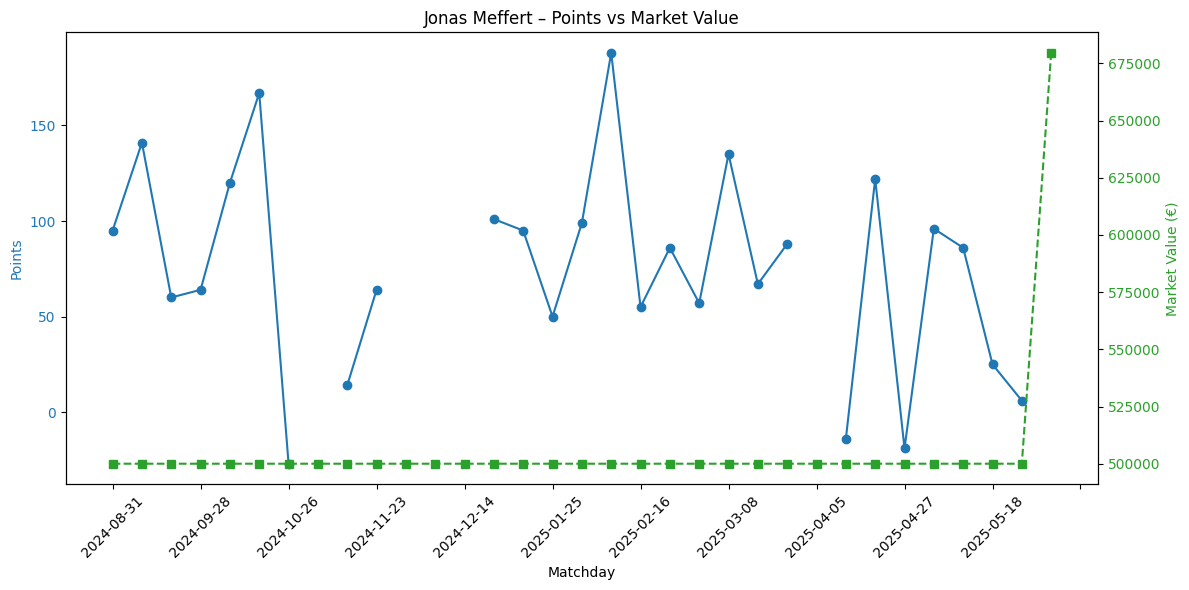

In [15]:
# we need competition_id, player_id, timeframe
competition_id = 1 # 1 is for Bundesliga, info from github issue thread
last_mv_values = 365 # in days, max 365
last_pfm_values = 50 # in matchdays
player_name = "Jonas Meffert" # Example player

# Get player ID
player_id = get_player_id(token, competition_id, player_name)

# Get player info
player_info = get_player_info(token, competition_id, player_id)
player_team_id = player_info["team_id"]
player_df = pd.DataFrame([player_info])

# Get player market value
market_value = get_player_market_value(token, competition_id, player_id, last_mv_values)
mv_df = pd.DataFrame(market_value)

# Get player performance
performance = get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id)
p_df = pd.DataFrame(performance)

display(p_df)

# Merge on 'date'
merged_df = pd.merge(p_df, mv_df, on="date", how="inner")
merged_df = player_df.merge(merged_df, how="cross")

#display(merged_df)

# Ensure correct column names (adjust if needed)
points_col = "p"          # from performance
mv_col = "mv"         # from market value
matchday_col = "date"            # common key

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Points (left y-axis)
color = "tab:blue"
ax1.set_xlabel("Matchday")
ax1.set_ylabel("Points", color=color)
ax1.plot(merged_df[matchday_col], merged_df[points_col], 
         marker="o", linestyle="-", color=color, label="Points")
ax1.tick_params(axis="y", labelcolor=color)

# X-axis formatting
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=15))  # max ~15 ticks
plt.xticks(rotation=45)

# Create second axis for Market Value (right y-axis)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Market Value (€)", color=color)
ax2.plot(merged_df[matchday_col], merged_df[mv_col], 
         marker="s", linestyle="--", color=color, label="Market Value")
ax2.tick_params(axis="y", labelcolor=color)

# Title and layout
plt.title(f"{player_name} – Points vs Market Value")
fig.tight_layout()
plt.show()